# DB2 Data Cleaning

## Introduction

In this project, we aim to predict the performance of database transfers based on various system and transfer-related parameters. We utilize performance benchmark datasets from nine different experiments to train and evaluate several machine learning models. The target variable for our prediction is the `TotaltransferTime`.

The steps involved in this project are as follows:
1. **Data Loading and Concatenation**: Load performance data from nine experiments and concatenate them into a single DataFrame.
2. **Feature Engineering**: Aggregate relevant table statistics and add them to the main DataFrame.
3. **Data Cleaning**: Remove duplicate rows and handle missing values.
4. **Data Visualization**: Visualize data to understand correlations and distributions.
5. **Data Preprocessing**: Create preprocessing pipelines for numerical and categorical data.
6. **Model Selection and Training**: Train multiple machine learning models and evaluate their performance.

## 1. Data Loading and Concatenation

In [2]:
import sklearn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
import dalex as dx
import matplotlib.pyplot as plt

In [3]:
tables = {
    'Table name': ["LINEITEM1", "GIGANTICORDERS", "ORDERS2", "ORDERS3", "ORDERS4", "ORDERS5", "ORDERS6", "ORDERS7", "ORDERS8", "ORDERS10", "ORDERSWIDE2"],
    'Data size(MB)': [674, 5477, 1825, 1825, 1825, 1825, 1825, 1825, 1825, 275, 5337],
    'number of rows': [3894493, 45000000, 15000000, 15000000, 15000000, 15000000, 15000000, 15000000,  15000000, 1993416, 15000000],
    'number of columns': [16, 9, 9, 9, 9, 9, 9, 9, 9, 9, 27]
    }

tables_df = pd.DataFrame(tables)
tables_df.head()

,Table name,Data size(MB),number of rows,number of columns
0,LINEITEM1,674,3894493,16
1,GIGANTICORDERS,5477,45000000,9
2,ORDERS2,1825,15000000,9
3,ORDERS3,1825,15000000,9
4,ORDERS4,1825,15000000,9


In [4]:
source_machine_specs = {
    'RAM (GB)': [120],
    'CPU': [16],
    'Disk (GB)': [20],
    'External Disk (GB)': [576]
    }

source_machine_df = pd.DataFrame(source_machine_specs)
source_machine_df.head()

,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,120,16,20,576


In [5]:
# Load the performance benchmark datasets
exp1_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp1/performanceBenchmark.csv')
exp2_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp2/performanceBenchmark.csv')
exp3_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp3/performanceBenchmark.csv')
exp4_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp4/performanceBenchmark.csv')
exp5_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp5/performanceBenchmark.csv')
exp6_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp6/performanceBenchmark.csv')
exp7_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp7/performanceBenchmark.csv')
exp8_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp8/performanceBenchmark.csv')
exp9_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp9/performanceBenchmark.csv')
exp10_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp10/performanceBenchmark.csv')
exp11_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp11/performanceBenchmark.csv')
exp12_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp12/performanceBenchmark.csv')
exp13_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp13/performanceBenchmark.csv')
exp14_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp14/performanceBenchmark.csv')
exp15_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp15/performanceBenchmark.csv')
exp16_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp16/performanceBenchmark.csv')
exp17_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp17/performanceBenchmark.csv')
exp18_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp18/performanceBenchmark.csv')
exp19_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp19/performanceBenchmark.csv')
exp20_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp20/performanceBenchmark.csv')
exp21_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp21/performanceBenchmark.csv')
exp22_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp22/performanceBenchmark.csv')
exp23_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp23/performanceBenchmark.csv')
exp24_performance_df = pd.read_csv('https://raw.githubusercontent.com/yorku-ease/DmML/main/Data/DB2%20Performance%20Datasets/exp24/performanceBenchmark.csv')

In [6]:
exp1_performance_df.head()

,Experiment Number,compress,sourceDatabasetoTargetDatabase,tables,maxStreams,binary,Experiment startTime,TotalExperimentTime,TotaltransferTime,totalPrecheckTime,TotalClearTime
0,1,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3296.018193,3266.620216,32.906244,NaN
1,2,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,622.369466,588.320576,3.208371,NaN
2,3,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1945.972293,1920.935266,3.742569,NaN
3,4,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,3834.102760,3783.924402,6.611556,NaN
4,5,NO,testdb_testdb,LINEITEM1_ORDERS2_ORDERS10,1,False,1.717525e+09,1933.460342,1901.642637,6.197286,NaN


In [7]:
print(exp10_performance_df.columns)

Index(['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase',
       'tables', 'maxStreams', 'binary', 'Experiment startTime',
       'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime',
       'TotalClearTime'],
      dtype='object')


Concatenating all the experiments

In [8]:
performance_dfs = [exp1_performance_df, exp2_performance_df, exp3_performance_df, 
                   exp4_performance_df, exp5_performance_df, exp6_performance_df, 
                   exp7_performance_df, exp8_performance_df, exp9_performance_df,
                   exp10_performance_df, exp11_performance_df, exp12_performance_df,
                   exp13_performance_df, exp14_performance_df, exp15_performance_df,
                   exp16_performance_df, exp17_performance_df, exp18_performance_df,
                   exp19_performance_df, exp20_performance_df, exp21_performance_df,
                   exp22_performance_df, exp23_performance_df, exp24_performance_df]

performance_df = pd.concat(performance_dfs, ignore_index=True)

In [9]:
performance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372 entries, 0 to 371
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Experiment Number               372 non-null    int64  
 1   compress                        372 non-null    object 
 2   sourceDatabasetoTargetDatabase  372 non-null    object 
 3   tables                          372 non-null    object 
 4   maxStreams                      372 non-null    int64  
 5   binary                          372 non-null    bool   
 6   Experiment startTime            372 non-null    float64
 7   TotalExperimentTime             372 non-null    float64
 8   TotaltransferTime               372 non-null    float64
 9   totalPrecheckTime               372 non-null    float64
 10  TotalClearTime                  329 non-null    float64
dtypes: bool(1), float64(5), int64(2), object(3)
memory usage: 29.6+ KB


The `calculate_table_sums` function calculates and aggregates the total data size, number of rows, and number of columns for specified table names within a dataframe. It adds these aggregated values as new features to the original dataframe.

## 2. Feature Engineering
We define a function `calculate_table_sums` to calculate and aggregate the total data size, number of rows, and number of columns for specified table names within the DataFrame.


In [10]:
def calculate_table_sums(exp_df, tables_df):

    # Extract table names
    table_names_series = exp_df['tables'].str.split('_', expand=False)
    
    # Initialize lists to store the sums
    data_size_sum = []
    rows_sum = []
    columns_sum = []
    print(data_size_sum, rows_sum, columns_sum)

    # Iterate over each row of table names
    for table_names in table_names_series:
        # Filter the info dataframe for the current table names
        filtered_info = tables_df[tables_df['Table name'].isin(table_names)]
        # print(filtered_info)
        # Calculate the sums
        data_size_sum.append(filtered_info['Data size(MB)'].sum())
        rows_sum.append(filtered_info['number of rows'].sum())
        columns_sum.append(filtered_info['number of columns'].sum())
        # print(data_size_sum, rows_sum, columns_sum)


    # Add the sums as new features in the initial dataframe
    exp_df['Data size sum (MB)'] = data_size_sum
    exp_df['Number of rows sum'] = rows_sum
    exp_df['Number of columns sum'] = columns_sum

    
    exp_df = exp_df[['Experiment Number', 'compress', 'sourceDatabasetoTargetDatabase', 'tables', 'Data size sum (MB)', 'Number of rows sum', 'Number of columns sum', 'maxStreams', 'binary', 'Experiment startTime', 'TotalExperimentTime', 'TotaltransferTime', 'totalPrecheckTime', 'TotalClearTime']]

    return exp_df

In [11]:
performance_df = calculate_table_sums(performance_df, tables_df)

[] [] []


In [12]:
performance_df.drop(labels=['Experiment Number', 'sourceDatabasetoTargetDatabase', 'tables', 'TotalExperimentTime', 'totalPrecheckTime', 'TotalClearTime', 'Experiment startTime'], axis=1, inplace=True)

In [13]:
performance_df.head(10)

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime
0,NO,2774,20887909,34,1,False,3266.620216
1,NO,2774,20887909,34,1,False,588.320576
2,NO,2774,20887909,34,1,False,1920.935266
3,NO,2774,20887909,34,1,False,3783.924402
4,NO,2774,20887909,34,1,False,1901.642637
5,GZIP,2774,20887909,34,1,False,928.459119
6,GZIP,2774,20887909,34,1,False,4838.436518
7,GZIP,2774,20887909,34,1,False,3387.124010
8,GZIP,2774,20887909,34,1,False,2479.712331
9,GZIP,2774,20887909,34,1,False,2414.547340


In [14]:
# Concatenate the experiment tables with the system specs
df2_repeated = pd.concat([source_machine_df]*len(performance_df), ignore_index=True)


result_df = pd.concat([performance_df, df2_repeated], axis=1)


In [15]:
result_df.head()

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576


## 3. Data Cleaning

### 3.1 Check for duplicate rows and remove them if any.


In [16]:
result_df.duplicated().sum()

16

In [17]:
result_df.drop_duplicates()

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...
367,NO,5337,15000000,27,5,False,563.725937,120,16,20,576
368,NO,5337,15000000,27,5,False,907.880295,120,16,20,576
369,NO,5337,15000000,27,5,False,550.628901,120,16,20,576
370,NO,5337,15000000,27,5,False,523.224117,120,16,20,576


### 3.2 Handle the missing values


In [18]:
result_df.isna().sum()

compress                 0
Data size sum (MB)       0
Number of rows sum       0
Number of columns sum    0
maxStreams               0
binary                   0
TotaltransferTime        0
RAM (GB)                 0
CPU                      0
Disk (GB)                0
External Disk (GB)       0
dtype: int64

In [19]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...
367,NO,5337,15000000,27,5,False,563.725937,120,16,20,576
368,NO,5337,15000000,27,5,False,907.880295,120,16,20,576
369,NO,5337,15000000,27,5,False,550.628901,120,16,20,576
370,NO,5337,15000000,27,5,False,523.224117,120,16,20,576


In [20]:
result_df = result_df.drop(result_df[result_df['TotaltransferTime'] == 0].index)


In [21]:
result_df

,compress,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
0,NO,2774,20887909,34,1,False,3266.620216,120,16,20,576
1,NO,2774,20887909,34,1,False,588.320576,120,16,20,576
2,NO,2774,20887909,34,1,False,1920.935266,120,16,20,576
3,NO,2774,20887909,34,1,False,3783.924402,120,16,20,576
4,NO,2774,20887909,34,1,False,1901.642637,120,16,20,576
...,...,...,...,...,...,...,...,...,...,...,...
367,NO,5337,15000000,27,5,False,563.725937,120,16,20,576
368,NO,5337,15000000,27,5,False,907.880295,120,16,20,576
369,NO,5337,15000000,27,5,False,550.628901,120,16,20,576
370,NO,5337,15000000,27,5,False,523.224117,120,16,20,576


In [22]:
# print(result_df['TotaltransferTime'].tolist())

In [23]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 330 entries, 0 to 371
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   compress               330 non-null    object 
 1   Data size sum (MB)     330 non-null    int64  
 2   Number of rows sum     330 non-null    int64  
 3   Number of columns sum  330 non-null    int64  
 4   maxStreams             330 non-null    int64  
 5   binary                 330 non-null    bool   
 6   TotaltransferTime      330 non-null    float64
 7   RAM (GB)               330 non-null    int64  
 8   CPU                    330 non-null    int64  
 9   Disk (GB)              330 non-null    int64  
 10  External Disk (GB)     330 non-null    int64  
dtypes: bool(1), float64(1), int64(8), object(1)
memory usage: 28.7+ KB


## 4. Visualizing the Data

### 4.1 Correlation Matrix using Pearson correlation coefficient


In [24]:
result_df.describe()

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
count,330.000000,3.300000e+02,330.000000,330.000000,330.000000,330.0,330.0,330.0,330.0
mean,6409.815152,4.295966e+07,30.778788,7.169697,3208.731732,120.0,16.0,20.0,576.0
std,4445.944869,3.574816e+07,20.497227,3.177857,3467.449465,0.0,0.0,0.0,0.0
min,2774.000000,1.500000e+07,9.000000,1.000000,83.768511,120.0,16.0,20.0,576.0
25%,2774.000000,2.088791e+07,9.000000,5.000000,983.567741,120.0,16.0,20.0,576.0
50%,5337.000000,2.088791e+07,27.000000,10.000000,2306.756122,120.0,16.0,20.0,576.0
75%,5477.000000,4.500000e+07,34.000000,10.000000,3812.803699,120.0,16.0,20.0,576.0
max,23589.000000,1.650000e+08,99.000000,10.000000,19425.012430,120.0,16.0,20.0,576.0


In [25]:
# Calculate the correlation matrix
corr_matrix = result_df.corr(numeric_only=True)
corr_matrix

,Data size sum (MB),Number of rows sum,Number of columns sum,maxStreams,binary,TotaltransferTime,RAM (GB),CPU,Disk (GB),External Disk (GB)
Data size sum (MB),1.000000,0.934334,0.741820,0.142272,-0.186796,0.693578,NaN,NaN,NaN,NaN
Number of rows sum,0.934334,1.000000,0.690383,0.155039,-0.193273,0.729806,NaN,NaN,NaN,NaN
Number of columns sum,0.741820,0.690383,1.000000,0.106737,-0.160609,0.533351,NaN,NaN,NaN,NaN
maxStreams,0.142272,0.155039,0.106737,1.000000,-0.117031,0.057349,NaN,NaN,NaN,NaN
binary,-0.186796,-0.193273,-0.160609,-0.117031,1.000000,-0.122133,NaN,NaN,NaN,NaN
TotaltransferTime,0.693578,0.729806,0.533351,0.057349,-0.122133,1.000000,NaN,NaN,NaN,NaN
RAM (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CPU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
External Disk (GB),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 4.2 Correlation with regard to the target "Total Transfer Time"


In [26]:
corr_matrix["TotaltransferTime"].sort_values(ascending=False)

TotaltransferTime        1.000000
Number of rows sum       0.729806
Data size sum (MB)       0.693578
Number of columns sum    0.533351
maxStreams               0.057349
binary                  -0.122133
RAM (GB)                      NaN
CPU                           NaN
Disk (GB)                     NaN
External Disk (GB)            NaN
Name: TotaltransferTime, dtype: float64

### 4.3 Histogram


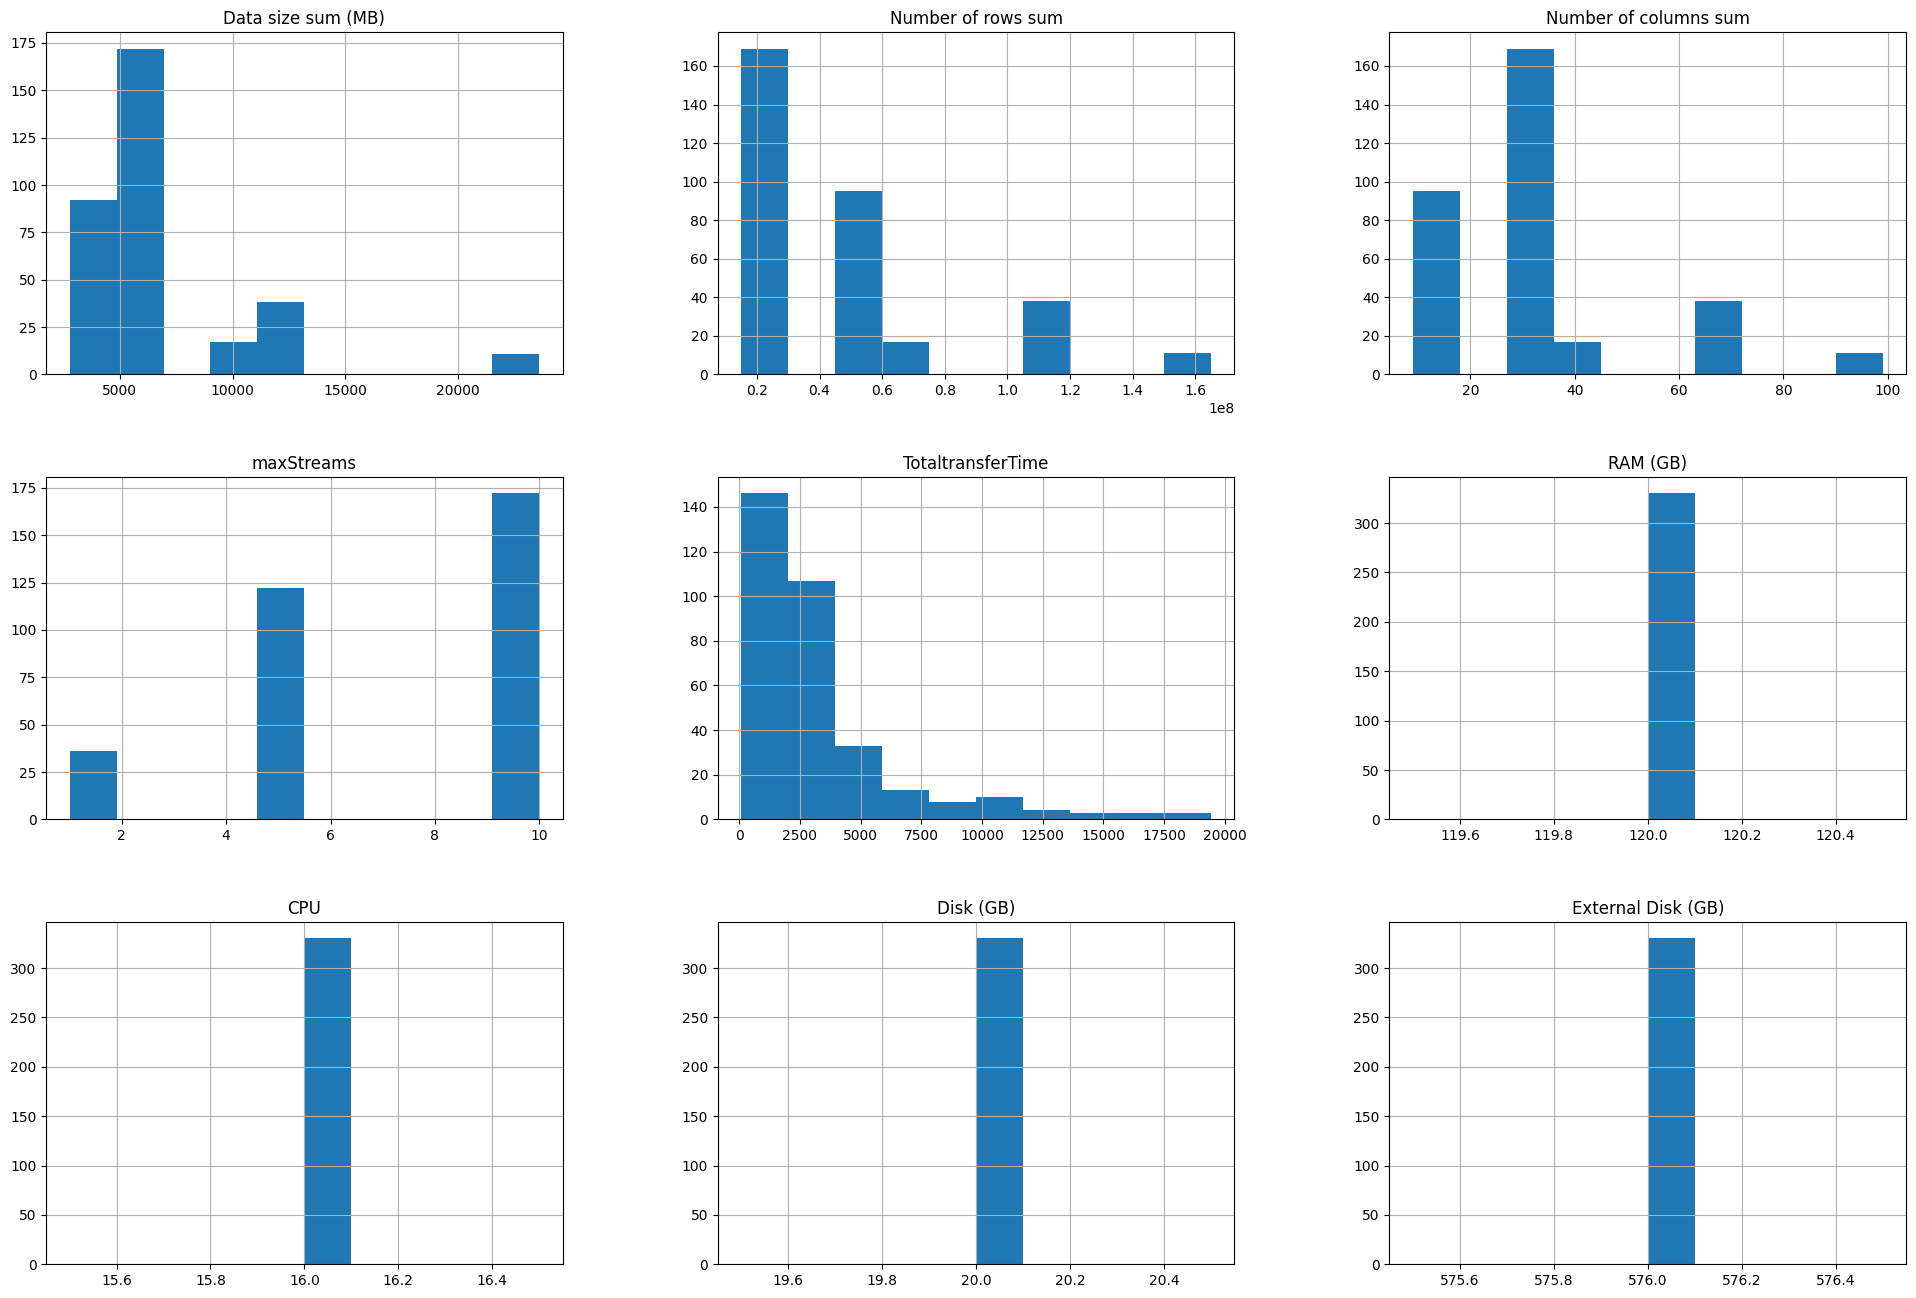

In [27]:
result_df.hist(figsize=(24, 16))
plt.show()

### 4.4 Pairwise correlation using seaborn


In [28]:
# Uncomment to generate pairplot (disabled for performance reasons)

# sns.pairplot(result_df)

## 5. Preprocessing

### 5.1 Create a pipeline


In [29]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [30]:
# Separate numerical and categorical columns
num_cols = result_df.select_dtypes(include='number').columns.to_list()
cat_cols = result_df.select_dtypes(exclude='number').columns.to_list()

# Exclude the target from numerical columns
num_cols.remove("TotaltransferTime")

# Create pipelines for numeric and categorical columns
num_pipeline = make_pipeline(SimpleImputer(strategy='mean'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

# Use ColumnTransformer to set the estimators and transformations
preprocessing = ColumnTransformer([('num', num_pipeline, num_cols),
                                   ('cat', cat_pipeline, cat_cols)],
                                    remainder='passthrough'
                                 )

In [31]:
# Display the pipeline
preprocessing

ColumnTransformer(remainder='passthrough',
                  transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Data size sum (MB)', 'Number of rows sum',
                                  'Number of columns sum', 'maxStreams',
                                  'RAM (GB)', 'CPU', 'Disk (GB)',
                                  'External Disk (GB)']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehotencoder',
                                                  OneHotEncoder())]),
                                 ['compress', 'binary'])])

In [32]:
# Apply the preprocessing pipeline on the dataset
result_df_prepared = preprocessing.fit_transform(result_df)

# Scikit-learn strips the column headers, so just add them back on afterward.
feature_names = preprocessing.get_feature_names_out()
result_df_prepared = pd.DataFrame(data=result_df_prepared, columns=feature_names)

result_df_prepared

,num__Data size sum (MB),num__Number of rows sum,num__Number of columns sum,num__maxStreams,num__RAM (GB),num__CPU,num__Disk (GB),num__External Disk (GB),cat__compress_GZIP,cat__compress_LZ4,cat__compress_NO,cat__binary_False,cat__binary_True,remainder__TotaltransferTime
0,-0.819024,-0.618361,0.157392,-1.944413,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3266.620216
1,-0.819024,-0.618361,0.157392,-1.944413,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,588.320576
2,-0.819024,-0.618361,0.157392,-1.944413,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1920.935266
3,-0.819024,-0.618361,0.157392,-1.944413,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3783.924402
4,-0.819024,-0.618361,0.157392,-1.944413,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1901.642637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,-0.241668,-0.783316,-0.184636,-0.683792,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,563.725937
326,-0.241668,-0.783316,-0.184636,-0.683792,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,907.880295
327,-0.241668,-0.783316,-0.184636,-0.683792,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,550.628901
328,-0.241668,-0.783316,-0.184636,-0.683792,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,523.224117


## 6. Selecting Model and Training

### 6.1 Split the dataset into a training dataset (80%) and testing dataset (20%).


In [33]:
from sklearn.model_selection import train_test_split

# Splitting data into features and target variable
X = result_df_prepared.drop(["remainder__TotaltransferTime"], axis=1)
y = result_df_prepared["remainder__TotaltransferTime"]

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(264, 13) (264,) (66, 13) (66,)


### 6.2 Define a function to report regression metrics


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def regression_report(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    report = {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

    for metric, value in report.items():
        print(f"{metric}: {value:.4f}")

    return {
        "Mean Absolute Error (MAE)": mae,
        "Mean Squared Error (MSE)": mse,
        "Root Mean Squared Error (RMSE)": rmse,
        "R² Score": r2
    }

### 6.3 Train and Evaluate Models

We will train and evaluate several models, including Decision Tree, Random Forest, Gradient Boosting, and XGBoost.

#### Decision Tree Regressor

In [35]:
# Dictionary to store the reports
reports = {}
feature_importances = {}

Hyperparameter tuning using Random Search 

In [36]:
# Decision Tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.tree import DecisionTreeRegressor

In [37]:
# Randomized Search
param_dist = {
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20)
}

dt_model = DecisionTreeRegressor(random_state=42)
random_search = RandomizedSearchCV(dt_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search): {best_score_random}\n")

# Train the best model from Randomized Search
best_dt_model_random = DecisionTreeRegressor(**best_params_random, random_state=42)
best_dt_model_random.fit(X_train, y_train)
y_pred_dt_random = best_dt_model_random.predict(X_test)

print("Decision Tree Regressor Report (Random Search):")
reports["Decision Tree (Random Search)"] = regression_report(y_test, y_pred_dt_random)

Best Parameters (Random Search): {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (Random Search): 0.6958190319225194

Decision Tree Regressor Report (Random Search):
Mean Absolute Error (MAE): 1407.2911
Mean Squared Error (MSE): 5858456.2785
Root Mean Squared Error (RMSE): 2420.4248
R² Score: 0.3870


In [38]:
# Grid Search
param_grid = {
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dtree_reg = DecisionTreeRegressor(random_state=42)
grid_search = GridSearchCV(estimator=dtree_reg, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid}")
print(f"Best Score (Grid Search): {best_score_grid}\n")

# Train the best model from Grid Search
best_dt_model_grid = DecisionTreeRegressor(**best_params_grid, random_state=42)
best_dt_model_grid.fit(X_train, y_train)
y_pred_dt_grid = best_dt_model_grid.predict(X_test)

print("Decision Tree Regressor Report (Grid Search):")
reports["Decision Tree (Grid Search)"] = regression_report(y_test, y_pred_dt_grid)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Parameters (Grid Search): {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score (Grid Search): -3712813.4936432736

Decision Tree Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1407.2961
Mean Squared Error (MSE): 5888170.7847
Root Mean Squared Error (RMSE): 2426.5553
R² Score: 0.3839


In [39]:
# Choose the best model based on R² Score
best_model = None
best_report = None

if reports["Decision Tree (Random Search)"]["R² Score"] > reports["Decision Tree (Grid Search)"]["R² Score"]:
    best_model = best_dt_model_random
    best_report = reports["Decision Tree (Random Search)"]
    best_params = best_params_random
else:
    best_model = best_dt_model_grid
    best_report = reports["Decision Tree (Grid Search)"]
    best_params = best_params_grid

print("Best Model Report:")
for metric, value in best_report.items():
    print(f"{metric}: {value:.4f}")

print(f"Best Parameters: {best_params}")

# Store feature importances for the best model
feature_names = X_train.columns  # Assuming X_train is a DataFrame
dt_importances = np.zeros(len(feature_names))
dt_importances[:len(best_model.feature_importances_)] = best_model.feature_importances_
feature_importances["Decision Tree"] = dt_importances

Best Model Report:
Mean Absolute Error (MAE): 1407.2911
Mean Squared Error (MSE): 5858456.2785
Root Mean Squared Error (RMSE): 2420.4248
R² Score: 0.3870
Best Parameters: {'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 2}


#### Random Forest Regressor


In [40]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor

In [41]:
# Default Random Forest
default_rf_model = RandomForestRegressor(random_state=42)
default_rf_model.fit(X_train, y_train)
y_pred_rf_default = default_rf_model.predict(X_test)

print("Random Forest Regressor Report (Default):")
reports["Random Forest (Default)"] = regression_report(y_test, y_pred_rf_default)

Random Forest Regressor Report (Default):
Mean Absolute Error (MAE): 1385.9143
Mean Squared Error (MSE): 5810812.7645
Root Mean Squared Error (RMSE): 2410.5627
R² Score: 0.3920


In [42]:
# Randomized Search for Random Forest
param_dist = {
    'n_estimators': randint(10, 200),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': randint(1, 20),
    'max_leaf_nodes': randint(2, 20)
}

rf_model = RandomForestRegressor(random_state=42)
random_search = RandomizedSearchCV(rf_model, param_distributions=param_dist, 
                                   n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)
best_params_random = random_search.best_params_
best_score_random = random_search.best_score_

print(f"Best Parameters (Random Search): {best_params_random}")
print(f"Best Score (Random Search): {best_score_random}\n")

# Train the best model from Randomized Search
best_rf_model_random = RandomForestRegressor(**best_params_random, random_state=42)
best_rf_model_random.fit(X_train, y_train)
y_pred_rf_random = best_rf_model_random.predict(X_test)

print("Random Forest Regressor Report (Random Search):")
reports["Random Forest (Random Search)"] = regression_report(y_test, y_pred_rf_random)

Best Parameters (Random Search): {'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 19, 'n_estimators': 133}
Best Score (Random Search): 0.7130570450741207

Random Forest Regressor Report (Random Search):
Mean Absolute Error (MAE): 1341.4756
Mean Squared Error (MSE): 5186049.8427
Root Mean Squared Error (RMSE): 2277.2900
R² Score: 0.4574


In [43]:
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]
}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, 
                           cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params_grid = grid_search.best_params_
best_score_grid = grid_search.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid}")
print(f"Best Score (Grid Search): {best_score_grid}\n")

# Train the best model from Grid Search
best_rf_model_grid = RandomForestRegressor(**best_params_grid, random_state=42)
best_rf_model_grid.fit(X_train, y_train)
y_pred_rf_grid = best_rf_model_grid.predict(X_test)

print("Random Forest Regressor Report (Grid Search):")
reports["Random Forest (Grid Search)"] = regression_report(y_test, y_pred_rf_grid)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters (Grid Search): {'max_depth': 6, 'max_features': None, 'max_leaf_nodes': 9, 'n_estimators': 50}
Best Score (Grid Search): -3940880.794992467

Random Forest Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1374.1225
Mean Squared Error (MSE): 5236793.8783
Root Mean Squared Error (RMSE): 2288.4042
R² Score: 0.4521


In [44]:
# Choose the best model based on R² Score
best_model_rf = None
best_report_rf = None

if "Random Forest (Default)" in reports and \
   "Random Forest (Random Search)" in reports and \
   "Random Forest (Grid Search)" in reports:
    
    r2_default = reports["Random Forest (Default)"]["R² Score"]
    r2_random = reports["Random Forest (Random Search)"]["R² Score"]
    r2_grid = reports["Random Forest (Grid Search)"]["R² Score"]
    
    if r2_default >= r2_random and r2_default >= r2_grid:
        best_model_rf = default_rf_model
        best_report_rf = reports["Random Forest (Default)"]
        best_params_rf = "Default Parameters"
    elif r2_random >= r2_default and r2_random >= r2_grid:
        best_model_rf = best_rf_model_random
        best_report_rf = reports["Random Forest (Random Search)"]
        best_params_rf = best_params_random
    else:
        best_model_rf = best_rf_model_grid
        best_report_rf = reports["Random Forest (Grid Search)"]
        best_params_rf = best_params_grid

    print("Best Random Forest Model Report:")
    for metric, value in best_report_rf.items():
        print(f"{metric}: {value:.4f}")

    print(f"Best Parameters: {best_params_rf}")

    # Store feature importances for the best Random Forest model
    feature_names = X_train.columns  # Assuming X_train is a DataFrame
    rf_importances = np.zeros(len(feature_names))
    rf_importances[:len(best_model_rf.feature_importances_)] = best_model_rf.feature_importances_
    feature_importances["Random Forest"] = rf_importances
else:
    print("One of the searches did not return a valid model.")

Best Random Forest Model Report:
Mean Absolute Error (MAE): 1341.4756
Mean Squared Error (MSE): 5186049.8427
Root Mean Squared Error (RMSE): 2277.2900
R² Score: 0.4574
Best Parameters: {'max_depth': 8, 'max_features': 'sqrt', 'max_leaf_nodes': 19, 'n_estimators': 133}


In [45]:
# 7. Model Interpretation using Dalex
exp = dx.Explainer(best_model_rf, X_train, y_train)
exp.model_performance()

Preparation of a new explainer is initiated

  -> data              : 264 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 264 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x00000205528C91C0> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 1.06e+03, mean = 3.22e+03, max = 1.66e+04
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -6.93e+03, mean = 20.0, max = 7.48e+03
  -> model_info        : package sklearn

A new explainer has been created!


,mse,rmse,r2,mae,mad
RandomForestRegressor,2.889400e+06,1699.823428,0.770483,1109.138369,719.845941


In [46]:
# # Random Forest Explainer
# rf_explainer = dx.Explainer(rf_pipeline, X_test, y_test, label="Random Forest Model")

In [47]:
# # Prediction Breakdown for Random Forest
# rf_pred_breakdown = rf_explainer.predict_parts(X_test.iloc[sample_idx])
# rf_pred_breakdown.plot(show=False)
# plt.title('Random Forest: Prediction Breakdown')
# plt.show()

# # Feature Importance for Random Forest
# rf_feature_importance = rf_explainer.model_parts()
# rf_feature_importance.plot(show=False)
# plt.title('Random Forest: Feature Importance')
# plt.show()

# # Model Performance for Random Forest
# rf_model_perf = rf_explainer.model_performance()
# rf_model_perf.plot(show=False)
# plt.title('Random Forest: Model Performance')
# plt.show()

# # Residual Plot for Random Forest
# rf_residual_plot = rf_explainer.model_performance().plot_residual(show=False)
# plt.title('Random Forest: Residual Plot')
# plt.show()


#### Gradient Boosting Regressor


In [48]:
# Gradient Boosting
from sklearn.ensemble import GradientBoostingRegressor

In [49]:
# Gradient Boosting Default
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)
y_pred_gb_default = gb_model.predict(X_test)

print("Gradient Boosting Regressor Report (Default):")
reports["Gradient Boosting (Default)"] = regression_report(y_test, y_pred_gb_default)


Gradient Boosting Regressor Report (Default):
Mean Absolute Error (MAE): 1386.7936
Mean Squared Error (MSE): 5696225.7876
Root Mean Squared Error (RMSE): 2386.6767
R² Score: 0.4040


In [50]:
# Randomized Search for Gradient Boosting
param_dist_gb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(1, 10)
}

gb_model_random = GradientBoostingRegressor(random_state=42)
random_search_gb = RandomizedSearchCV(gb_model_random, param_distributions=param_dist_gb,
                                      n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_gb.fit(X_train, y_train)
best_params_random_gb = random_search_gb.best_params_
best_score_random_gb = random_search_gb.best_score_

print(f"Best Parameters (Random Search): {best_params_random_gb}")
print(f"Best Score (Random Search): {best_score_random_gb}\n")

# Train the best model from Randomized Search
best_gb_model_random = GradientBoostingRegressor(**best_params_random_gb, random_state=42)
best_gb_model_random.fit(X_train, y_train)
y_pred_gb_random = best_gb_model_random.predict(X_test)

print("Gradient Boosting Regressor Report (Random Search):")
reports["Gradient Boosting (Random Search)"] = regression_report(y_test, y_pred_gb_random)


Best Parameters (Random Search): {'learning_rate': 0.06888977841391714, 'max_depth': 5, 'n_estimators': 116}
Best Score (Random Search): 0.7276244072005931

Gradient Boosting Regressor Report (Random Search):
Mean Absolute Error (MAE): 1398.6291
Mean Squared Error (MSE): 5864730.8139
Root Mean Squared Error (RMSE): 2421.7206
R² Score: 0.3864


In [51]:
# Grid Search for Gradient Boosting
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

grid_search_gb = GridSearchCV(estimator=gb_model_random, param_grid=param_grid_gb,
                              cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_gb.fit(X_train, y_train)
best_params_grid_gb = grid_search_gb.best_params_
best_score_grid_gb = grid_search_gb.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid_gb}")
print(f"Best Score (Grid Search): {best_score_grid_gb}\n")

# Train the best model from Grid Search
best_gb_model_grid = GradientBoostingRegressor(**best_params_grid_gb, random_state=42)
best_gb_model_grid.fit(X_train, y_train)
y_pred_gb_grid = best_gb_model_grid.predict(X_test)

print("Gradient Boosting Regressor Report (Grid Search):")
reports["Gradient Boosting (Grid Search)"] = regression_report(y_test, y_pred_gb_grid)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters (Grid Search): {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Score (Grid Search): -3406032.534150003

Gradient Boosting Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1405.1774
Mean Squared Error (MSE): 5884457.2998
Root Mean Squared Error (RMSE): 2425.7900
R² Score: 0.3843


In [52]:
# Choose the best Gradient Boosting model based on R² Score
best_model_gb = None
best_report_gb = None
best_params_gb = None

if "Gradient Boosting (Default)" in reports and \
   "Gradient Boosting (Random Search)" in reports and \
   "Gradient Boosting (Grid Search)" in reports:

    r2_default_gb = reports["Gradient Boosting (Default)"]["R² Score"]
    r2_random_gb = reports["Gradient Boosting (Random Search)"]["R² Score"]
    r2_grid_gb = reports["Gradient Boosting (Grid Search)"]["R² Score"]

    if r2_default_gb >= r2_random_gb and r2_default_gb >= r2_grid_gb:
        best_model_gb = gb_model
        best_report_gb = reports["Gradient Boosting (Default)"]
        best_params_gb = "Default Parameters"
    elif r2_random_gb >= r2_default_gb and r2_random_gb >= r2_grid_gb:
        best_model_gb = best_gb_model_random
        best_report_gb = reports["Gradient Boosting (Random Search)"]
        best_params_gb = best_params_random_gb
    else:
        best_model_gb = best_gb_model_grid
        best_report_gb = reports["Gradient Boosting (Grid Search)"]
        best_params_gb = best_params_grid_gb

    print("Best Gradient Boosting Model Report:")
    for metric, value in best_report_gb.items():
        print(f"{metric}: {value:.4f}")

    print(f"Best Parameters: {best_params_gb}")

    # Store feature importances for the best Gradient Boosting model
    gb_importances = np.zeros(len(feature_names))
    gb_importances[:len(best_model_gb.feature_importances_)] = best_model_gb.feature_importances_
    feature_importances["Gradient Boosting"] = gb_importances
else:
    print("One of the searches did not return a valid model.")

Best Gradient Boosting Model Report:
Mean Absolute Error (MAE): 1386.7936
Mean Squared Error (MSE): 5696225.7876
Root Mean Squared Error (RMSE): 2386.6767
R² Score: 0.4040
Best Parameters: Default Parameters


#### XGBoost Regressor


In [53]:
# XGBoost
import xgboost as xgb


In [54]:
# XGBoost Default
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb_default = xgb_model.predict(X_test)

print("XGBoost Regressor Report (Default):")
reports["XGBoost (Default)"] = regression_report(y_test, y_pred_xgb_default)

XGBoost Regressor Report (Default):
Mean Absolute Error (MAE): 1407.2959
Mean Squared Error (MSE): 5888170.2599
Root Mean Squared Error (RMSE): 2426.5552
R² Score: 0.3839


In [55]:
# Randomized Search for XGBoost
param_dist_xgb = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4)
}

xgb_model_random = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
random_search_xgb = RandomizedSearchCV(xgb_model_random, param_distributions=param_dist_xgb,
                                       n_iter=100, cv=5, random_state=42, n_jobs=-1)
random_search_xgb.fit(X_train, y_train)
best_params_random_xgb = random_search_xgb.best_params_
best_score_random_xgb = random_search_xgb.best_score_

print(f"Best Parameters (Random Search): {best_params_random_xgb}")
print(f"Best Score (Random Search): {best_score_random_xgb}")

# Train the best model from Randomized Search
best_xgb_model_random = xgb.XGBRegressor(**best_params_random_xgb, objective='reg:squarederror', random_state=42)
best_xgb_model_random.fit(X_train, y_train)
y_pred_xgb_random = best_xgb_model_random.predict(X_test)

print("XGBoost Regressor Report (Random Search):")
reports["XGBoost (Random Search)"] = regression_report(y_test, y_pred_xgb_random)

Best Parameters (Random Search): {'colsample_bytree': 0.8170160922219597, 'learning_rate': 0.111762815367752, 'max_depth': 8, 'n_estimators': 168, 'subsample': 0.7001847274422337}
Best Score (Random Search): 0.7283592777625454
XGBoost Regressor Report (Random Search):
Mean Absolute Error (MAE): 1425.2055
Mean Squared Error (MSE): 6126917.4022
Root Mean Squared Error (RMSE): 2475.2611
R² Score: 0.3589


In [56]:
# Grid Search for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model_random, param_grid=param_grid_xgb,
                               cv=5, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search_xgb.fit(X_train, y_train)
best_params_grid_xgb = grid_search_xgb.best_params_
best_score_grid_xgb = grid_search_xgb.best_score_

print(f"Best Parameters (Grid Search): {best_params_grid_xgb}")
print(f"Best Score (Grid Search): {best_score_grid_xgb}")

# Train the best model from Grid Search
best_xgb_model_grid = xgb.XGBRegressor(**best_params_grid_xgb, objective='reg:squarederror', random_state=42)
best_xgb_model_grid.fit(X_train, y_train)
y_pred_xgb_grid = best_xgb_model_grid.predict(X_test)

print("XGBoost Regressor Report (Grid Search):")
reports["XGBoost (Grid Search)"] = regression_report(y_test, y_pred_xgb_grid)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


c:\Users\hasti\anaconda3\envs\DMBenchML\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters (Grid Search): {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.6}
Best Score (Grid Search): -3385873.1889788723
XGBoost Regressor Report (Grid Search):
Mean Absolute Error (MAE): 1433.5383
Mean Squared Error (MSE): 6115178.7035
Root Mean Squared Error (RMSE): 2472.8887
R² Score: 0.3602


In [57]:
# Choose the best XGBoost model based on R² Score
best_model_xgb = None
best_report_xgb = None
best_params_xgb = None

if "XGBoost (Default)" in reports and \
   "XGBoost (Random Search)" in reports and \
   "XGBoost (Grid Search)" in reports:

    r2_default_xgb = reports["XGBoost (Default)"]["R² Score"]
    r2_random_xgb = reports["XGBoost (Random Search)"]["R² Score"]
    r2_grid_xgb = reports["XGBoost (Grid Search)"]["R² Score"]

    if r2_default_xgb >= r2_random_xgb and r2_default_xgb >= r2_grid_xgb:
        best_model_xgb = xgb_model
        best_report_xgb = reports["XGBoost (Default)"]
        best_params_xgb = "Default Parameters"
    elif r2_random_xgb >= r2_default_xgb and r2_random_xgb >= r2_grid_xgb:
        best_model_xgb = best_xgb_model_random
        best_report_xgb = reports["XGBoost (Random Search)"]
        best_params_xgb = best_params_random_xgb
    else:
        best_model_xgb = best_xgb_model_grid
        best_report_xgb = reports["XGBoost (Grid Search)"]
        best_params_xgb = best_params_grid_xgb

    print("Best XGBoost Model Report:")
    for metric, value in best_report_xgb.items():
        print(f"{metric}: {value:.4f}")

    print(f"Best Parameters: {best_params_xgb}")

    # Store feature importances for the best XGBoost model
    xgb_importances = np.zeros(len(feature_names))
    xgb_importances[:len(best_model_xgb.feature_importances_)] = best_model_xgb.feature_importances_
    feature_importances["XGBoost"] = xgb_importances
else:
    print("One of the searches did not return a valid model.")

Best XGBoost Model Report:
Mean Absolute Error (MAE): 1407.2959
Mean Squared Error (MSE): 5888170.2599
Root Mean Squared Error (RMSE): 2426.5552
R² Score: 0.3839
Best Parameters: Default Parameters


### 6.4 Summary of Model Performance

Convert the reports dictionary to a DataFrame and display the results.


In [58]:
# Convert the reports dictionary to a DataFrame
reports_df = pd.DataFrame.from_dict(reports, orient='index')
print(reports_df)

# # Save the DataFrame to a CSV file
# reports_df.to_csv("model_performance_reports.csv", index=True)

                                   Mean Absolute Error (MAE)  \
Decision Tree (Random Search)                    1407.291104   
Decision Tree (Grid Search)                      1407.296069   
Random Forest (Default)                          1385.914337   
Random Forest (Random Search)                    1341.475575   
Random Forest (Grid Search)                      1374.122458   
Gradient Boosting (Default)                      1386.793599   
Gradient Boosting (Random Search)                1398.629103   
Gradient Boosting (Grid Search)                  1405.177444   
XGBoost (Default)                                1407.295874   
XGBoost (Random Search)                          1425.205492   
XGBoost (Grid Search)                            1433.538300   

                                   Mean Squared Error (MSE)  \
Decision Tree (Random Search)                  5.858456e+06   
Decision Tree (Grid Search)                    5.888171e+06   
Random Forest (Default)                   

### 6.5 Feature Importances

Visualize the feature importances for each model.


In [59]:
# Save feature importances to a CSV file
feature_importances_df = pd.DataFrame(feature_importances, index=feature_names)
print(feature_importances_df)

# # Save the DataFrame to a CSV file
# feature_importances_df.to_csv("feature_importances.csv", index=True)

                            Decision Tree  Random Forest  Gradient Boosting  \
num__Data size sum (MB)          0.766655       0.281316           0.446218   
num__Number of rows sum          0.000126       0.281835           0.146606   
num__Number of columns sum       0.014823       0.271632           0.218177   
num__maxStreams                  0.120814       0.093633           0.129494   
num__RAM (GB)                    0.000000       0.000000           0.000000   
num__CPU                         0.000000       0.000000           0.000000   
num__Disk (GB)                   0.000000       0.000000           0.000000   
num__External Disk (GB)          0.000000       0.000000           0.000000   
cat__compress_GZIP               0.042670       0.023316           0.025474   
cat__compress_LZ4                0.016582       0.018959           0.013863   
cat__compress_NO                 0.025733       0.018652           0.005566   
cat__binary_False                0.004934       0.00

In [60]:
reports_df

,Mean Absolute Error (MAE),Mean Squared Error (MSE),Root Mean Squared Error (RMSE),R² Score
Decision Tree (Random Search),1407.291104,5.858456e+06,2420.424814,0.387037
Decision Tree (Grid Search),1407.296069,5.888171e+06,2426.555333,0.383928
Random Forest (Default),1385.914337,5.810813e+06,2410.562748,0.392022
Random Forest (Random Search),1341.475575,5.186050e+06,2277.290022,0.457390
Random Forest (Grid Search),1374.122458,5.236794e+06,2288.404221,0.452081
Gradient Boosting (Default),1386.793599,5.696226e+06,2386.676725,0.404011
Gradient Boosting (Random Search),1398.629103,5.864731e+06,2421.720631,0.386381
Gradient Boosting (Grid Search),1405.177444,5.884457e+06,2425.790036,0.384317
XGBoost (Default),1407.295874,5.888170e+06,2426.555225,0.383928
XGBoost (Random Search),1425.205492,6.126917e+06,2475.261078,0.358948


In [61]:
# Find the row index where the max value occurs
max_value_index = reports_df["Root Mean Squared Error (RMSE)"].idxmax()

# Return the value from the first (unnamed) column in the same row
print(max_value_index)

XGBoost (Random Search)


In [62]:
feature_importances_df

,Decision Tree,Random Forest,Gradient Boosting,XGBoost
num__Data size sum (MB),0.766655,0.281316,0.446218,0.700400
num__Number of rows sum,0.000126,0.281835,0.146606,0.000077
num__Number of columns sum,0.014823,0.271632,0.218177,0.000296
num__maxStreams,0.120814,0.093633,0.129494,0.088905
num__RAM (GB),0.000000,0.000000,0.000000,0.000000
num__CPU,0.000000,0.000000,0.000000,0.000000
num__Disk (GB),0.000000,0.000000,0.000000,0.000000
num__External Disk (GB),0.000000,0.000000,0.000000,0.000000
cat__compress_GZIP,0.042670,0.023316,0.025474,0.075351
cat__compress_LZ4,0.016582,0.018959,0.013863,0.017924
